In [140]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# Empirical power laws
>Let's assume that the average energy consumption of the rat can be modelled with a power law of the form:
$$\frac{d E}{dt} = a + b v^\alpha(t)$$
such that:
    $$E = \int_0^T dE = \int_0^T \left(a+b v^\alpha (t)\right) dt$$
>where $E$ is the total energy consumed from $t=0$ s to the final time $t=T$ s, $v$ is the absolute velocity of the rat, $a$ the rat's power when the velocity is null, $\alpha \in \{1,2\}$. Such laws have been determined experimentally for different mammals and are available in literature. 

> **Setting up the optimal control problem**: Let's assume that our control parameter is the acceleration of the rat on the treadmill. The state can be expressed as:
$$    x=\begin{pmatrix}
    (v_r + v_t)t + x_0\\
    v_r + v_t
    \end{pmatrix}
\quad \textrm{and} \quad 
\dot{x}=\begin{pmatrix}
v_r + v_t\\
u
\end{pmatrix}$$
> where $v_r\leq 0$ is the velocity of the rat in its own frame of reference, $v_t>0$ the velocity of the treadmill, $u$ the acceleration of the rat and $x_0$ its initial position. We want to solve the following problem:
$$\begin{split}
\min_{\substack{ x \in [0,7]\times \mathbb{R}^N_x \\ u \in [0,7]\times \mathbb{R}^N_u}}  \int_{0}^{7} \left(a+b v_r(t)^\alpha \right) dt\\
\textrm{subject to:} \quad
\begin{cases}
\dot{x}=[v_r+v_t,u]^T\\
x(0) = [x_0,(v_t-v_{r}^{max}):0.1]   \\
x(T) = [x_f,(v_t-v_{r}^{max}):0.0]  \qquad t \ \in \ [0,7]\\
[0.0,-0.6] \leq x(t) \leq [L_{t},0.1]   \\
-u_{max} \leq u(t) \leq u_{max}
\end{cases}
\end{split}
\label{problem_pl}$$


>with $L_{t}=0.9$ m the length of the treadmill. The duration of the experiment is set to $7$ s. The velocity of the treadmill $v_t$ is set to 0.1 m.s$^{-1}$. The maximum velocity that the rat can manage is determined from experimental trajectories. We find that the rats can have a peak velocity of about 0.7 m.s$^{-1}$, which translates into a $0.6$ m.s$^{-1}$ velocity $\dot{x}$ in the frame of the laboratory. Let's assume that the rats can only run against the direction of the treadmill, such that their velocity is constrained to: $-0.7 \leq v_r(t)\leq 0.0$ or $-0.6 \leq \dot{x}(t) \leq 0.1$. The initial and final velocities are left free, whereas the initial and final positions are set to $x_0 = 0.0$ m and $x_f = 0.1$ m. The bounds of the control, the acceleration, are also evaluated from experimental data. It seems that an acceleration $u_{max}=7.5$ m.s$^{-2}$ is realistic. We will assume that the rat can accelerate symmetrically in both directions. We can solve this problem using a collocation method in CasADi. The only unknowns are parameters $a$, $b$ and $\alpha$ that will be chosen based on two articles.


> **Quadratic cost**: In 1958, Ralston investigated the energy expenditure of human participants walking around in a rectangular track at various speed. They wore respirometers such that the oxygen concentrations of the expired air could be measured and turned into an energy equivalent using Weir's method\cite{weir_new_1949}. Ralston settled for a power law quadratic in the velocity:
$$\dot{E}_W = 29+0.0053 v^2 \quad \textrm{cal/kg/min}$$
For a rat with $m_r = 0.3$ kg, we have:
$$\dot{E} = 0.61+1.109\times 10^{-4} v^2 \quad \textrm{J/s}$$

> **Linear cost**: Heglund Cavagna and Taylor measured the work necessary to move the center of mass of animals as a function of their velocity in a level walking task:
    $$\dot{E}_{CM,tot}/M_b = 0.685 v_g + 0.072 \qquad \textrm{W.kg}^{-1}$$
Assuming a mass $m_r = 0.3$ kg, one can rewrite (\ref{linear_cost}) as:
$$    \dot{E} = 0.2055 v_g + 0.0216 $$


> Optimal control computations: The two problems are solved simultaneously using CasADi's collocation technique.

In [141]:
def penalty_function(x,t,a,b,mux,mut,kxpenalty,steepnesst,vtapis):
    '''This function generates a spatio-temporal energy barrier: spatially centered around x = 'mux', with steepness 'kxpenalty'
    and temporally centered around t = 'mut', with steepness 'steepnesst'.'''
    kTt = mut/steepnesst
    max_height=10.0*(a+b*vtapis)                    # cost of running 10s at the velocity of the treadmill (max penalty)
    amplitude = max_height/(1+np.exp((t-mut)/kTt))  # penalty maximum at t=mut...
    kTx = mux/kxpenalty
    return(amplitude/(1+np.exp((x-mux)/kTx)))       # ...and x=mux

def reward_function(x,t,mux,mut,steepnesst):
    '''This function generates a spatio-temporal energy valley: spatially centered around x = mux (gaussian
    with variance sigma2), and starting temporally at t = mut with a slope determined by steepnesst'''
    sigma1 = 3.0        #temporal variance (of associated gaussian)
    kT = mut/steepnesst
    amplitude = -np.exp(-(t-mut)**2/2/sigma1**2)/(1+np.exp((-(t-mut))/kT))  #asymmetric time evolution (x=0)
    sigma2=0.01
    return(0.5*amplitude*np.exp(-(x-mux)**2/2/sigma2**2))                   #spatio-temporal evolution


def optimal_trajectory(cost,a,b,x0,xf,tf,vtapis,kxpenalty):
    '''This function takes parameters a, b, initial position x0 and final position xf and 
    computes the OC problem assuming either a linear cost (cost='linear', Int_0^T a+b*v dt), 
    or a quadratic one (cost='quadratic',Int_0^T a+b*v*v dt). It returns respectively the 
    optimal trajectory, the associated time array, the optimal 
    velocity and its associated time array.'''
    Ltread=0.9
    nk = 500
    mu=0.1    # Control discretization
    kT=mu/1
    
    
    # Declare variables
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1],u)
    if cost=='linear':  #Choose between linear and quadratic power law
        rhs["L"] = (a+b*fabs(x[1]-vtapis))+penalty_function(x[0],t,a,b,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)+reward_function(x[0],t,mux=0.1,mut=6.95,steepnesst=1000)
    elif cost=='quadratic':
        rhs["L"] = a+b*(x[1]-vtapis)**2+penalty_function(x[0],t,a,b,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)+reward_function(x[0],t,mux=0.1,mut=6.95,steepnesst=1000)
        
    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -7.5
    u_max = 7.5
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   vtapis-0.7, -inf]
    x_max =  [Ltread,vtapis,  inf]
    xi_min = [x0,  vtapis-0.7,  0.0]
    xi_max = [x0,  vtapis,  0.0]
    xf_min = [xf,  vtapis-0.7, -inf]
    xf_max = [xf,  vtapis,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)

def cost(cost,v,a,b,vtapis):
    cos=0
    dt=7/len(v)
    n=0
    if cost=='quadratic':
        for i in range(len(v)):
            cos+=(a+b*(v[i]-vtapis)**2)*dt
        print("Cost of constant running at vt: ",(a+b*vtapis**2)*7.0)
    elif cost=='linear':
        for i in range(len(v)):
            cos+=(a+b*fabs(v[i]-vtapis))*dt
        print("Cost of constant running at vt: ",(a+b*vtapis)*7.0)
    return(cos)

## Linear cost

> Firstly, let's compute the optimal trajectory minimizing a power law linear with respect to the velocity of the rat. Heglund, Cavagna & Taylor (1981) derived an average power law valid for all mammals (the mass of the rat is taken to be $m=0.3$ kg): 

$$\dot{E} = 0.2055 v_g + 0.0216$$


## Quadratic cost

In his 1958 paper, Ralston derived the following power law for people performing a walking task:
$$\dot{E}_W = 29+0.0053 v^2 \quad \textrm{cal/kg/min}$$
For a rat with $m_r = 0.3$ kg, we have:
$$\dot{E} = 0.61+1.109\times 10^{-4} v^2 \quad \textrm{J/s}$$

# Computations and plots









In [148]:
# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=1  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 8.0     # final time (duration of experiment)

# COMPUTATION
xl,xdotl,tl,accl,tal = optimal_trajectory(cost='linear',a=0.0216,b=0.2055,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty)
xq,xdotq,tq,accq,taccq = optimal_trajectory(cost='quadratic',a=0.61,b=1.109E-04,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    26993
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3000

Total number of variables............................:     6509
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     4506
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

   8 1.2749812e+001 2.05e-003 1.41e-001  -3.8 5.34e-001  -1.9 1.00e+000 1.00e+000h  1
   9 1.2681666e+001 3.20e-003 2.48e-001  -3.8 2.36e-001  -1.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2652713e+001 2.34e-004 4.19e-002  -3.8 7.35e-002  -1.1 7.19e-001 1.00e+000h  1
  11 1.2564483e+001 6.10e-003 4.22e-001  -3.8 2.75e-001  -1.5 6.11e-001 1.00e+000h  1
  12 1.2515219e+001 4.28e-004 2.86e-002  -3.8 9.10e-002  -1.1 6.43e-001 1.00e+000h  1
  13 1.2414742e+001 6.94e-003 3.78e-001  -3.8 2.28e-001  -1.6 8.76e-001 1.00e+000h  1
  14 1.2247728e+001 1.98e-002 5.12e-001  -3.8 1.61e+000  -2.1 1.00e+000 4.65e-001h  1
  15 1.2079567e+001 2.89e-002 5.93e-001  -3.8 7.53e-001  -1.6 9.33e-003 1.00e+000f  1
  16 1.2233883e+001 2.20e-002 9.25e-001  -3.8 3.72e-001  -1.2 1.00e+000 8.23e-001h  1
  17 1.2307640e+001 5.52e-003 2.41e+000  -3.8 3.74e-001  -0.8 2.71e-003 1.00e+000h  1
  18 1.2284868e+001 7.17e-005 9.82e-002  -3.8 5.35e-002  -0

Cost of constant running at vt:  4.270007763000001
Cost quadratic =  4.27004
Cost of constant running at vt:  0.29505
Cost linear =  0.276961


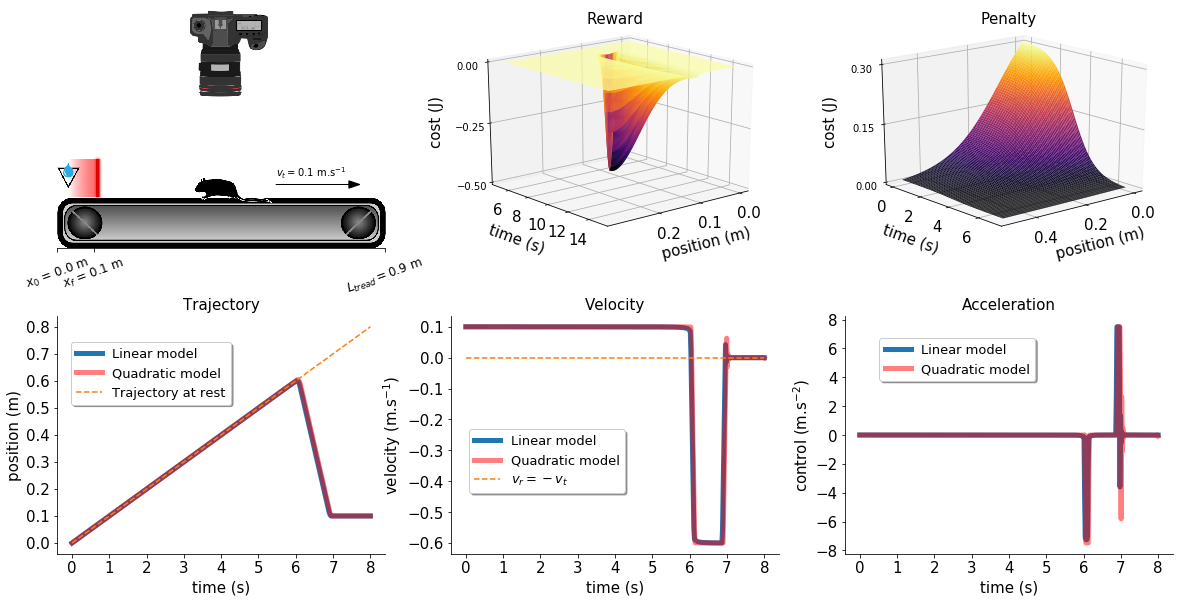

In [149]:
#COMPUTE ASSOCIATED COSTS
costq=cost('quadratic',xdotq,0.61,1.109E-04,vtapis)
print("Cost quadratic = ",costq)
costl=cost('linear',xdotl,0.0216,0.2055,vtapis)
print("Cost linear = ",costl)

#GENERATE FIGURE
fig3 = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=2)
gs = fig3.add_gridspec(6, 6)

# SCHEME OF THE TASK
f3_ax1 = fig3.add_subplot(gs[:3, :2])
img1 = mpimg.imread('experimental_setup.png')
f3_ax1.imshow(img1,aspect='auto')
f3_ax1.spines['top'].set_visible(False)
f3_ax1.spines['right'].set_visible(False) 
f3_ax1.spines['left'].set_visible(False) 
f3_ax1.set_yticks([])
f3_ax1.set_xticks([x0*1000,xf*1000,900])
plt.xticks(rotation=20)
f3_ax1.set_xticklabels([r'$x_0$ = '+str(x0)+' m',r'$x_f$ = '+str(xf)+' m',r'$L_{tread} = 0.9$ m'],size=12)
plt.arrow(600,470,200,0,head_width=20.0,color='black')
plt.text(600,450,r'$v_t = $'+str(vtapis)+' m.s$^{-1}$')

#REWARD FUNCTION
f3_ax2 = fig3.add_subplot(gs[:3, 2:4],projection="3d")
f3_ax2.set_title('Reward',size=15)
t = np.linspace(5,15,100)
x = np.linspace(0.0,0.30,100)
X,T = np.meshgrid(x,t)
Z = reward_function(X,T,mux=0.1,mut=6.95,steepnesst=1000)
f3_ax2.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.3, step=0.1))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax2.zaxis.set_rotate_label(False) 
f3_ax2.set_zlabel('cost (J)',size=15,labelpad=10,rotation=90)
f3_ax2.set_zticks(np.linspace(0,-0.5,3))
f3_ax2.view_init(20, 50)
plt.xticks(size = 15)
plt.yticks(size = 15)


#PENALTY FUNCTION
f3_ax3 = fig3.add_subplot(gs[:3, 4:],projection='3d')
f3_ax3.set_title('Penalty',size=15)
x = np.linspace(0.0,0.5,100)
t = np.linspace(0.0,7.0)
X,T = np.meshgrid(x,t)
Z = penalty_function(X,T,a=0.0216,b=0.2055,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)
f3_ax3.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.yticks(np.arange(0, 7, step=2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax3.zaxis.set_rotate_label(False) 
f3_ax3.set_zlabel('cost (J)',size=15,labelpad=10,rotation=90)
f3_ax3.set_zticks(np.linspace(0,0.3,3))
f3_ax3.view_init(20, 50)
plt.xticks(size = 15)
plt.yticks(size = 15)


#TRAJECTORY
f3_ax4 = fig3.add_subplot(gs[3:,:2])
f3_ax4.set_title('Trajectory',size=15)
plt.plot(tl,xl,label='Linear model',linewidth=5.0,alpha=1.0)
plt.plot(tq,xq,label='Quadratic model',linewidth=5.0,alpha=0.5,color='red')
plt.plot(tl,[0.1*t for t in tl],'--',label='Trajectory at rest')
f3_ax4.spines['top'].set_visible(False)
f3_ax4.spines['right'].set_visible(False) 
f3_ax4.legend(fontsize=13,bbox_to_anchor=(.55, .6),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('position (m)',size=15)
plt.xlabel('time (s)',size=15)


#VELOCITY
f3_ax5 = fig3.add_subplot(gs[3:, 2:4])
f3_ax5.set_title('Velocity',size=15)
plt.plot(tl,xdotl,label='Linear model',linewidth=5.0)
plt.plot(tq,xdotq,label='Quadratic model',linewidth=5.0,alpha=0.5,color='red')
plt.plot(tl,[0.0 for t in tl],'--',label=r'$v_r=-v_t$')
plt.ylabel(r'velocity (m.s$^{-1}$)',size=15)
plt.xlabel('time (s)',size = 15)
f3_ax5.spines['top'].set_visible(False)
f3_ax5.spines['right'].set_visible(False) 
f3_ax5.legend(fontsize=13,bbox_to_anchor=(.55, .55),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


#ACCELERATION
f3_ax6 = fig3.add_subplot(gs[3:, 4:])
f3_ax6.set_title('Acceleration',size=15)
plt.plot(tal,accl,label='Linear model',linewidth=5.0)
plt.plot(taccq,accq,label='Quadratic model',color='red',alpha=0.5,linewidth=5.0)
plt.ylabel(r'control (m.s$^{-2}$)',size=15)
plt.xlabel('time (s)',size=15)
f3_ax6.spines['top'].set_visible(False)
f3_ax6.spines['right'].set_visible(False) 
f3_ax6.legend(fontsize=13,bbox_to_anchor=(.6, .7),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


plt.savefig('Results'+str(kxpenalty)+'.pdf')
plt.show()